In [15]:
import os
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

In [ ]:
# Config
image_dir = './data_images'
img_size = (128, 128)
classes = ['Pinus_pinaster', 'Eucalyptus_globulus', 'Quercus_suber']
batch_size = 16
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Custom Dataset
class TreeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [18]:
# Load file paths and labels
all_paths = []
all_labels = []

for filename in os.listdir(image_dir):
    if filename.lower().endswith((".jpg", ".jpeg")):
        label = "_".join(filename.split("_")[:2])
        if label in classes:
            path = os.path.join(image_dir, filename)
            all_paths.append(path)
            all_labels.append(label)

# Show dataset distribution
label_counts = Counter(all_labels)
print("Dataset class distribution:")
for k, v in label_counts.items():
    print(f"{k}: {v}")

Dataset class distribution:
Eucalyptus_globulus: 146
Quercus_suber: 230
Pinus_pinaster: 217


In [19]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(all_labels)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_encoded), y=labels_encoded)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [20]:
# Dataset class
class TreeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [21]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

In [22]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_paths, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

train_dataset = TreeDataset(X_train, y_train, transform=train_transform)
test_dataset = TreeDataset(X_test, y_test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [23]:
# Initialize model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

/Users/diogogomes/.pyenv/versions/3.12.0/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/diogogomes/.pyenv/versions/3.12.0/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# Training loop with accuracy tracking
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        running_loss += loss.item()

    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Train Acc: {train_acc:.2f} - Val Acc: {val_acc:.2f}")

Epoch 1/20 - Loss: 36.3155 - Train Acc: 0.35 - Val Acc: 0.31
Epoch 2/20 - Loss: 29.4184 - Train Acc: 0.45 - Val Acc: 0.50
Epoch 3/20 - Loss: 25.9127 - Train Acc: 0.56 - Val Acc: 0.62
Epoch 4/20 - Loss: 22.6049 - Train Acc: 0.66 - Val Acc: 0.69
Epoch 5/20 - Loss: 20.8318 - Train Acc: 0.72 - Val Acc: 0.72
Epoch 6/20 - Loss: 17.9279 - Train Acc: 0.76 - Val Acc: 0.80
Epoch 7/20 - Loss: 16.8400 - Train Acc: 0.80 - Val Acc: 0.81
Epoch 8/20 - Loss: 15.1061 - Train Acc: 0.82 - Val Acc: 0.82
Epoch 9/20 - Loss: 13.3389 - Train Acc: 0.85 - Val Acc: 0.84
Epoch 10/20 - Loss: 12.9343 - Train Acc: 0.86 - Val Acc: 0.83
Epoch 11/20 - Loss: 10.6057 - Train Acc: 0.91 - Val Acc: 0.83
Epoch 12/20 - Loss: 9.9804 - Train Acc: 0.88 - Val Acc: 0.84
Epoch 13/20 - Loss: 10.7929 - Train Acc: 0.87 - Val Acc: 0.85


KeyboardInterrupt: 

In [ ]:
# saving model
import torch
torch.save(model, "resnet_model.pth")

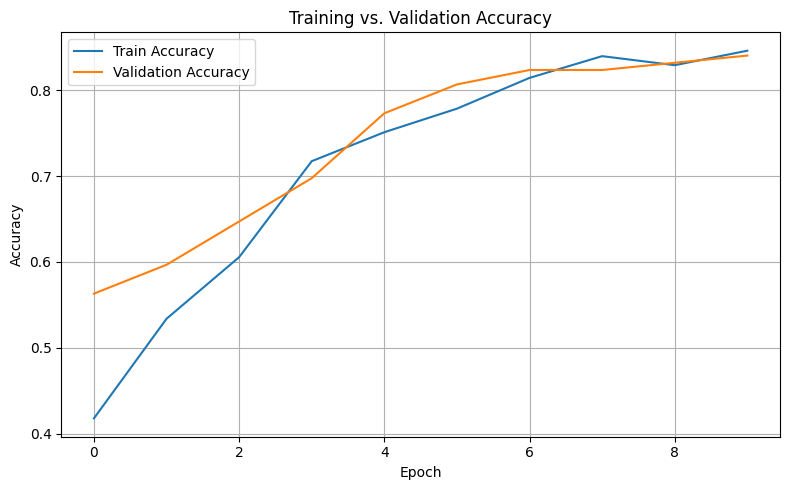

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Classification Report:
                     precision    recall  f1-score   support

Eucalyptus_globulus       0.69      0.76      0.72        29
     Pinus_pinaster       0.97      0.84      0.90        44
      Quercus_suber       0.84      0.89      0.86        46

           accuracy                           0.84       119
          macro avg       0.83      0.83      0.83       119
       weighted avg       0.85      0.84      0.84       119



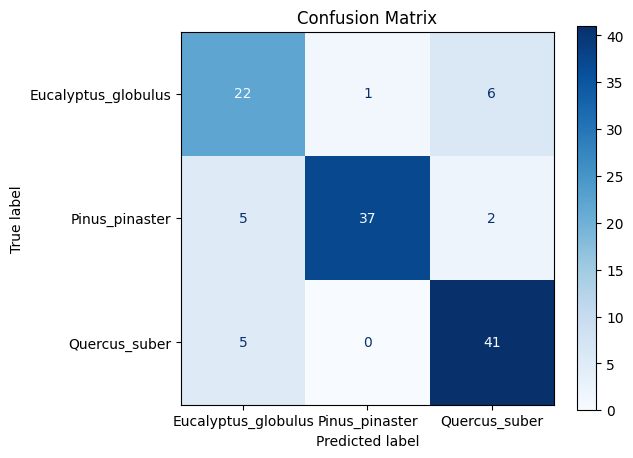

In [ ]:
# Confusion matrix and per-class report
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()